## Chapter 8 - Attention

- This chapter uses [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens) and is easiest to run on Linux
- Some code here including the  Attention implementation is borrowed from the excellent [ARENA course](https://arena-chapter1-transformer-interp.streamlit.app/) on transformers and mechanistic interpretability

In [1]:
import torch.nn as nn
import torch as t
import transformer_lens
from dataclasses import dataclass
from jaxtyping import Float, Int
from torch import Tensor
import einops
import matplotlib.pyplot as plt

### 8.1 Configuration and Helper Functions

In [2]:
## GPT-2 small model configuration
@dataclass
class Config:
    d_model: int = 768
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12
    
cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


In [3]:
# Test to ensure that our deconsutructed GPT-2 attention layers match the original
def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    output = layer(input)
    if isinstance(output, tuple):
        output = output[0]
    print("Output shape:", output.shape)
    try:
        reference_output = gpt2_layer(input)
    except:
        reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")
    assert 1 - (comparison.sum() / comparison.numel()) < 1e-5, "More than 0.01% of the values are incorrect"

In [4]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def forward(self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = (einops.einsum(
                normalized_resid_pre, self.W_Q, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            ) + self.b_Q)
        k = (einops.einsum(
                normalized_resid_pre, self.W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )+ self.b_K)
        v = (einops.einsum(
                normalized_resid_pre, self.W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
            )+ self.b_V)

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head**0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern, "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head"
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        attn_out = (
            einops.einsum(z, self.W_O, "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model")
            + self.b_O
        )

        return attn_out

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        """
        Applies a causal mask to attention scores, and returns masked scores.
        """
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores

### 8.2 Load Model and Move Data Through

In [5]:
device='cuda'
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [6]:
reference_text = "The American flag is red, white, and"

In [7]:
tokens = model.to_tokens(reference_text).to(device)
tokens

tensor([[50256,   464,  1605,  6056,   318,  2266,    11,  2330,    11,   290]],
       device='cuda:0')

In [8]:
logits, cache = model.run_with_cache(tokens) #Run through model

In [9]:
#Print sizes for first few tensors in cache
for i, k in enumerate(cache.keys()):
    print(k, cache[k].shape)
    if i>20: break #Just print first layer-ish

hook_embed torch.Size([1, 10, 768])
hook_pos_embed torch.Size([1, 10, 768])
blocks.0.hook_resid_pre torch.Size([1, 10, 768])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 768])
blocks.0.attn.hook_q torch.Size([1, 10, 12, 64])
blocks.0.attn.hook_k torch.Size([1, 10, 12, 64])
blocks.0.attn.hook_v torch.Size([1, 10, 12, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 12, 10, 10])
blocks.0.attn.hook_pattern torch.Size([1, 12, 10, 10])
blocks.0.attn.hook_z torch.Size([1, 10, 12, 64])
blocks.0.hook_attn_out torch.Size([1, 10, 768])
blocks.0.hook_resid_mid torch.Size([1, 10, 768])
blocks.0.ln2.hook_scale torch.Size([1, 10, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 10, 768])
blocks.0.mlp.hook_pre torch.Size([1, 10, 3072])
blocks.0.mlp.hook_post torch.Size([1, 10, 3072])
blocks.0.hook_mlp_out torch.Size([1, 10, 768])
blocks.0.hook_resid_post torch.Size([1, 10, 768])
blocks.1.hook_resid_pre torch.Size([1, 10, 768])
blocks.1.ln1.hook_scale

In [10]:
#Check that our attention implementation matches original model's results
load_gpt2_test(Attention, model.blocks[0].attn, cache["normalized", 0, "ln1"]) 

Input shape: torch.Size([1, 10, 768])
Output shape: torch.Size([1, 10, 768])
Reference output shape: torch.Size([1, 10, 768]) 

100.00% of the values are correct



### 8.3 Visualze data coming into layer

In [11]:
layer_id=2

cfg = Config(debug=True)
layer = Attention(cfg).to(device)
layer.load_state_dict(model.blocks[layer_id].attn.state_dict(), strict=False);

normalized_resid_pre=cache["normalized", layer_id, "ln1"] #Data coming into this layer
normalized_resid_pre.shape #Number of tokens x embedding dimension

torch.Size([1, 10, 768])

(np.float64(-0.5), np.float64(2.5), np.float64(9.5), np.float64(-0.5))

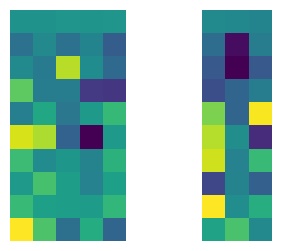

In [12]:
#Incoming data in Figure 8.5
x_numpy=normalized_resid_pre.detach().cpu().numpy()[0]

fig=plt.figure(0, (4, 3))
fig.add_subplot(1,2,1)
plt.imshow(x_numpy[:,:5]); plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(x_numpy[:,-3:]); plt.axis('off')

### 8.4 Visualize Queries and Keys

In [ ]:
head_id=0 # Layer 2, head 0 correspond to Figure 8.4 Panel !

In [13]:
W_Q=layer.W_Q 
W_K=layer.W_K
b_Q=layer.b_Q
b_K=layer.b_K 

In [14]:
W_Q.shape, W_K.shape

(torch.Size([12, 768, 64]), torch.Size([12, 768, 64]))

In [15]:
#There's more efficient ways to do this -> this is one matrix multiply per head 
qs=[]
for head_num in range(cfg.n_heads):
    qs.append(normalized_resid_pre[0] @ W_Q[head_num] +b_Q[head_num]) 
q=t.stack(qs, dim=0).unsqueeze(0).permute(0, 2, 1, 3) #Stack results together, add batch dimension, switch token and head dims.

In [16]:
q.shape

torch.Size([1, 10, 12, 64])

(np.float64(-0.5), np.float64(63.5), np.float64(9.5), np.float64(-0.5))

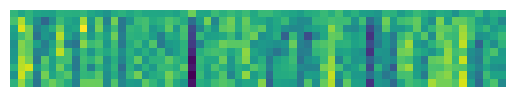

In [20]:
q_to_viz=q[0,:,head_id,:].detach().cpu().numpy()
plt.imshow(q_to_viz)
plt.axis('off')

In [21]:
k = (einops.einsum(
        normalized_resid_pre, W_K, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )+ b_K)

(np.float64(-0.5), np.float64(63.5), np.float64(9.5), np.float64(-0.5))

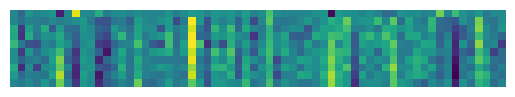

In [22]:
k_to_viz=k[0,:,head_id,:].detach().cpu().numpy()
plt.imshow(k_to_viz)
plt.axis('off')

### 8.5 Visualize Attention pattern

In [28]:
# Calculate attention scores, then scale and mask, and apply softmax to get probabilities
attn_scores = einops.einsum(
    q, k, "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K"
)

attn_scores_masked = layer.apply_causal_mask(attn_scores / layer.cfg.d_head**0.5)
attn_pattern = attn_scores_masked.softmax(-1)

In [29]:
attn_pattern.shape

torch.Size([1, 12, 10, 10])

(np.float64(-0.5), np.float64(8.5), np.float64(8.5), np.float64(-0.5))

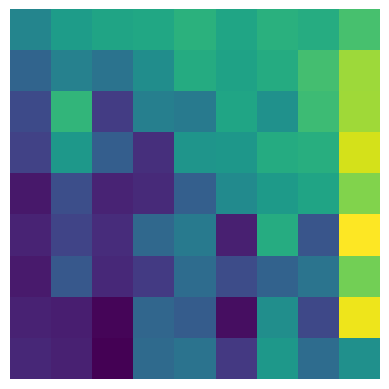

In [31]:
attn_scores_to_viz=attn_scores[0,head_id,:,:].detach().cpu().numpy()
plt.imshow(attn_scores_to_viz[1:,1:]) #Ignoring |Beginning of Sentence| token
plt.axis('off')

(np.float64(-0.5), np.float64(8.5), np.float64(8.5), np.float64(-0.5))

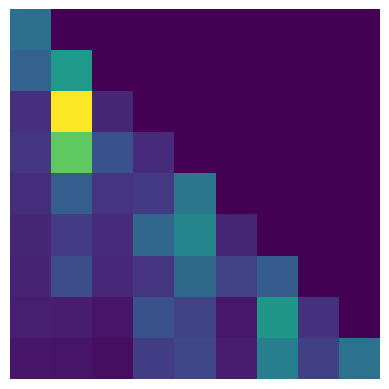

In [32]:
attn_pattern_to_viz=attn_pattern[0,head_id,:,:].detach().cpu().numpy()
plt.imshow(attn_pattern_to_viz[1:,1:])
plt.axis('off')

### 8.6 Visualize Values and Output

In [24]:
W_V=layer.W_V
W_O=layer.W_O 
b_V=layer.b_V 
b_O=layer.b_O

In [27]:
W_V.shape, W_O.shape

(torch.Size([12, 768, 64]), torch.Size([12, 64, 768]))

In [25]:
v = (einops.einsum(
        normalized_resid_pre, W_V, "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head"
    )+ b_V)

(np.float64(-0.5), np.float64(63.5), np.float64(9.5), np.float64(-0.5))

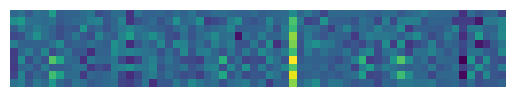

In [26]:
v_to_viz=v[0,:,head_id,:].detach().cpu().numpy()
plt.imshow(v_to_viz)
plt.axis('off')